Classification Report Summary:
               Genre  Precision (0)  Recall (0)  F1-Score (0)  Precision (1)  \
0           acoustic       0.741353    0.714746      0.727807       0.726225   
1          punk-rock       0.794352    0.698296      0.743233       0.732285   
2  progressive-house       0.823505    0.762323      0.791734       0.779996   
3          power-pop       0.816467    0.784869      0.800356       0.794081   
4                pop       0.726741    0.639505      0.680338       0.679865   
5           pop-film       0.893698    0.811912      0.850844       0.828629   
6              piano       0.745062    0.808066      0.775286       0.791709   
7              party       0.868822    0.795816      0.830718       0.812687   
8             pagode       0.855639    0.851411      0.853520       0.853025   
9              opera       0.861698    0.856293      0.858987       0.858041   

   Recall (1)  F1-Score (1)  Accuracy  Macro Precision  Macro Recall  \
0    0.752132   

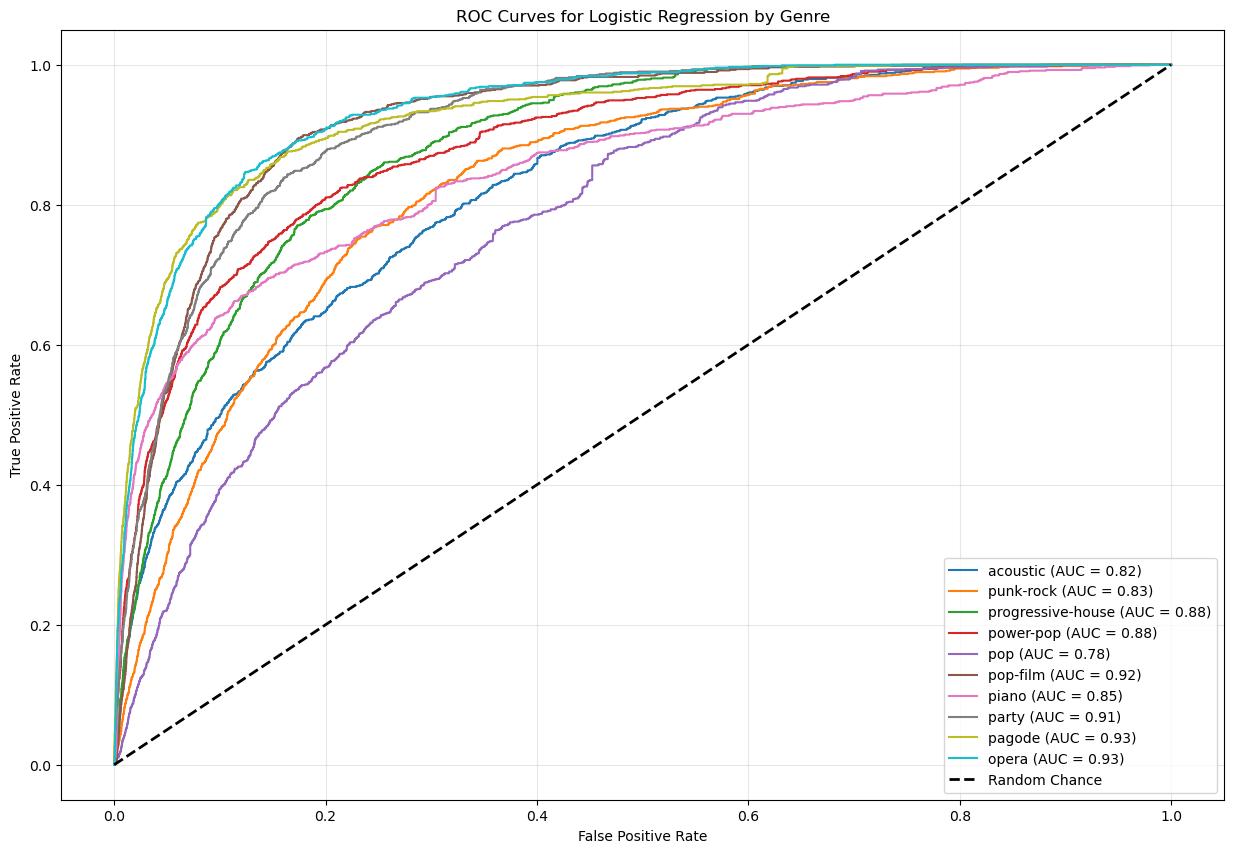

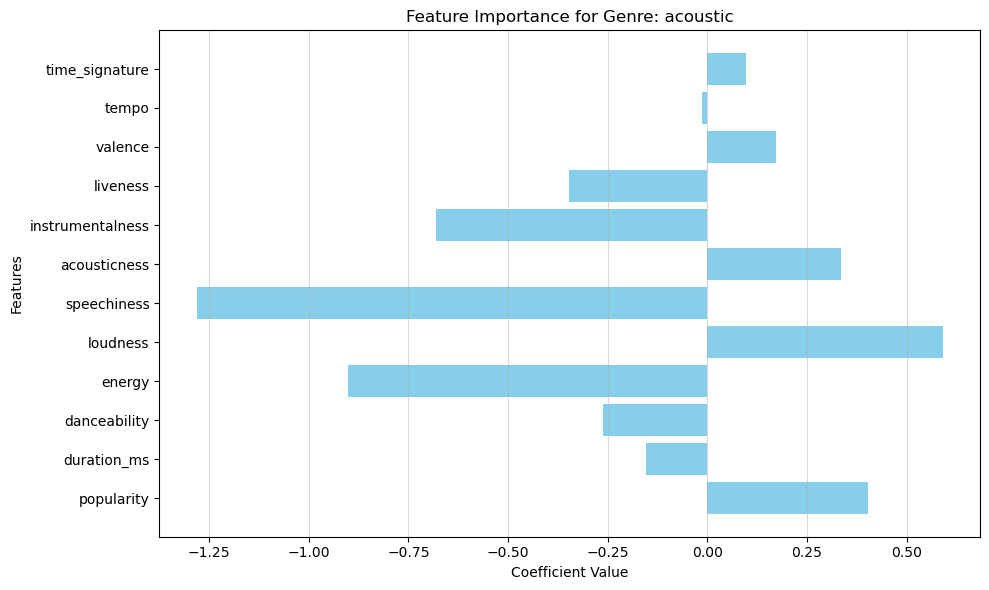

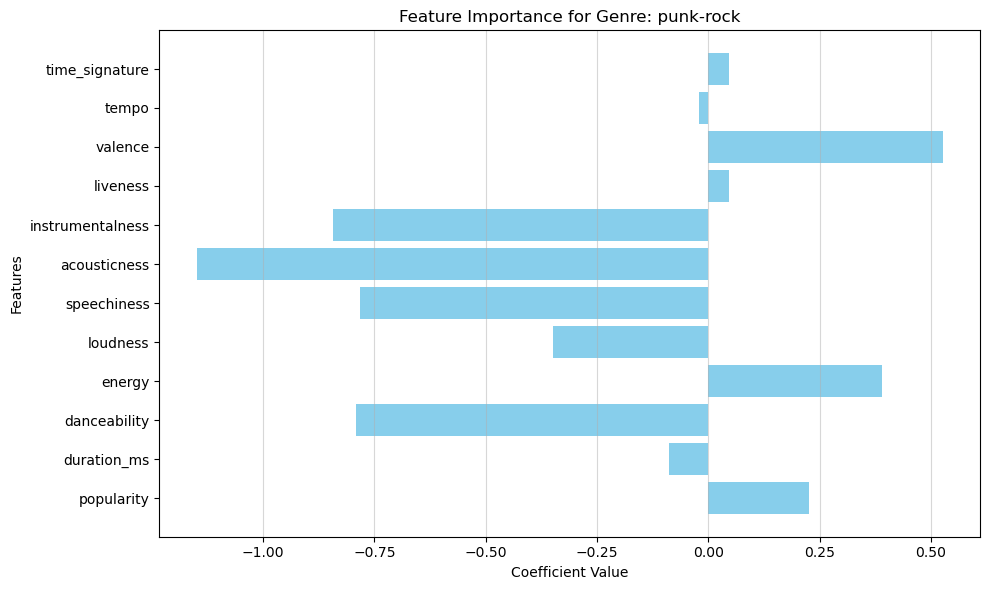

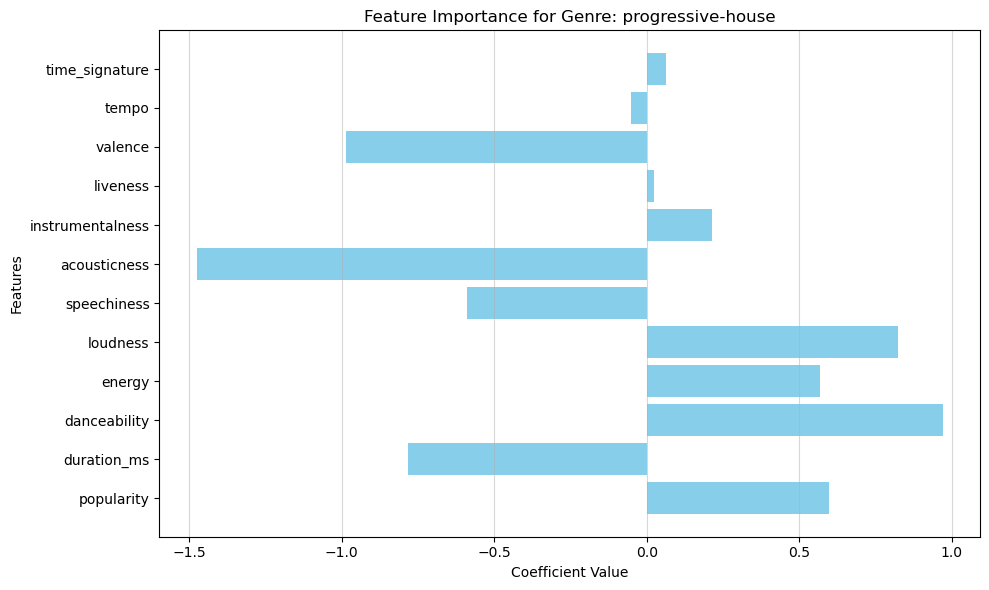

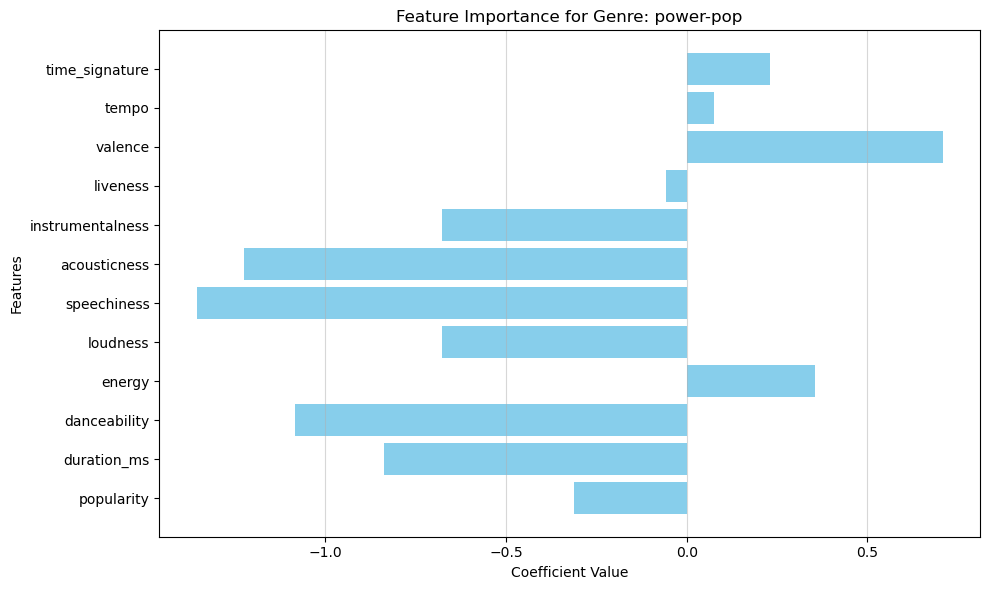

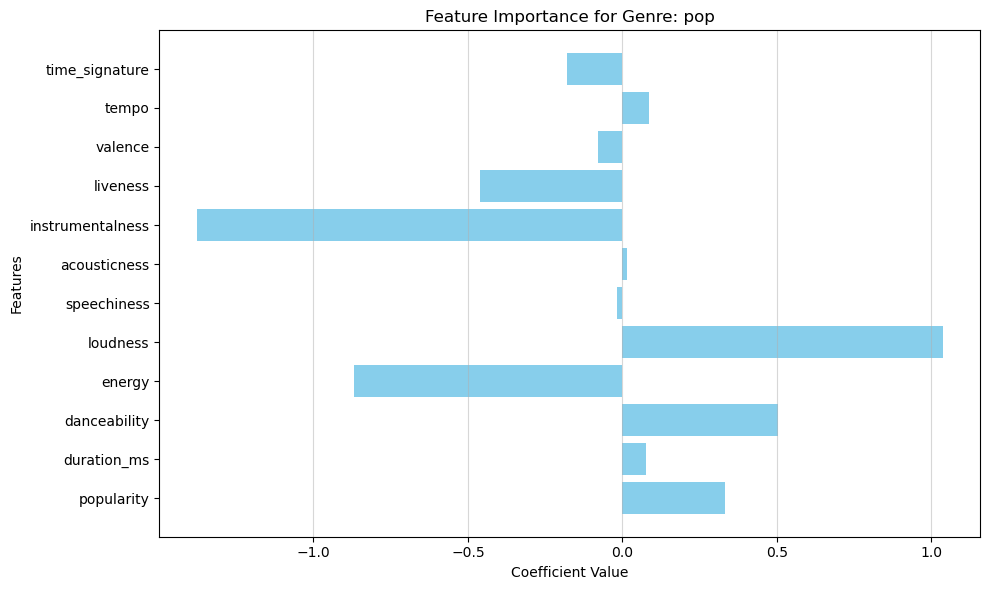

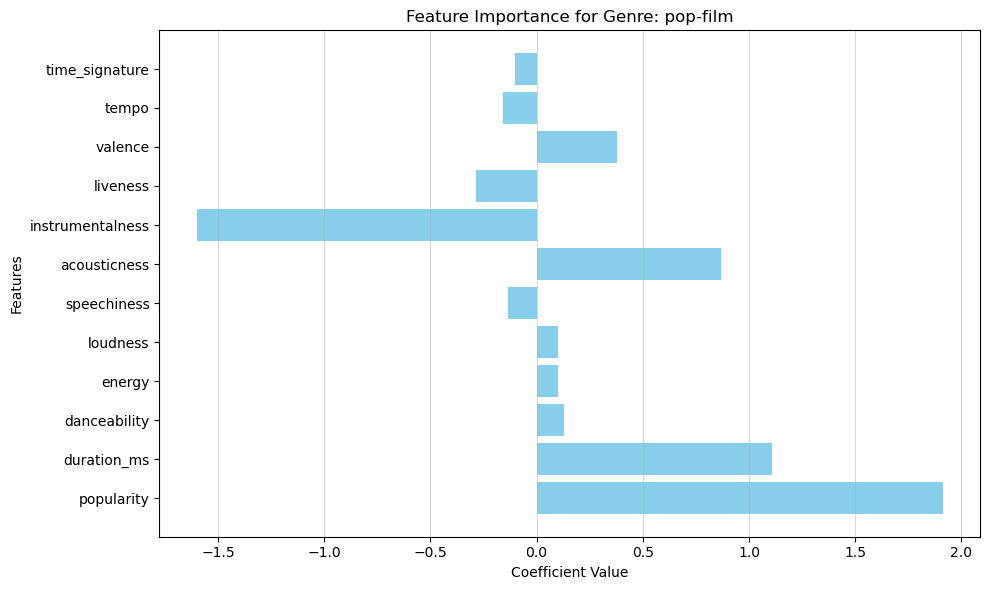

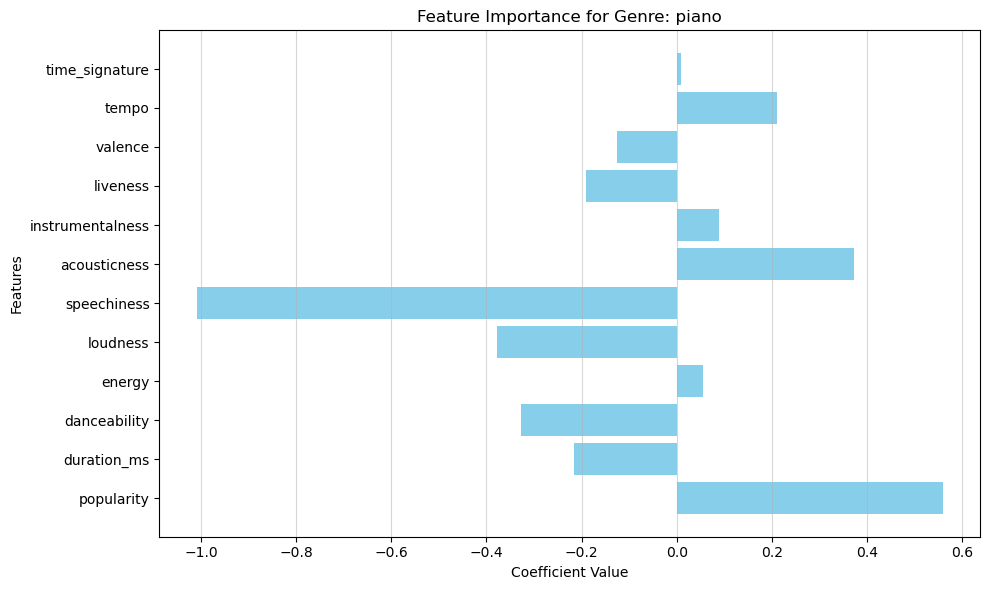

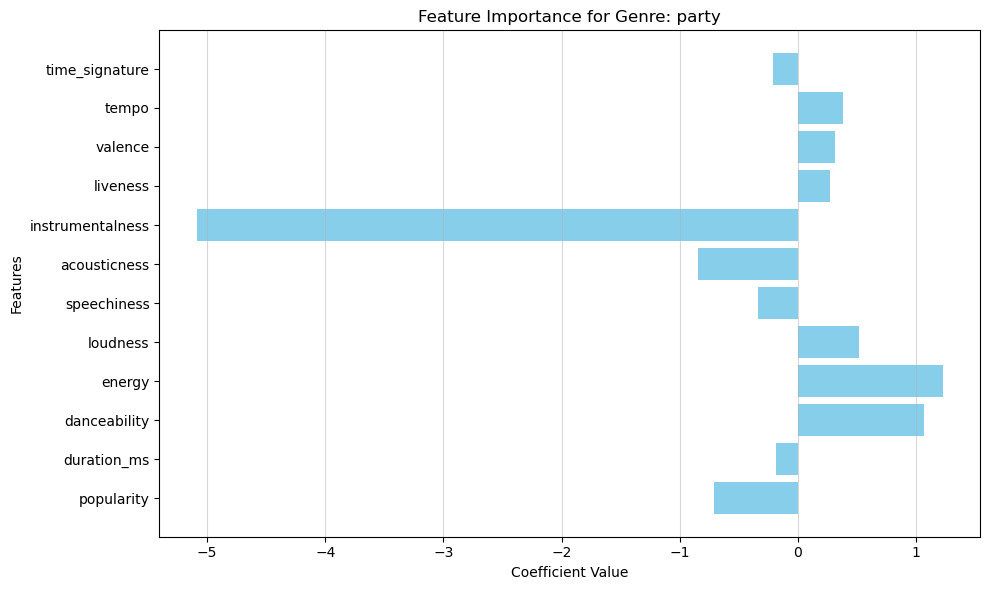

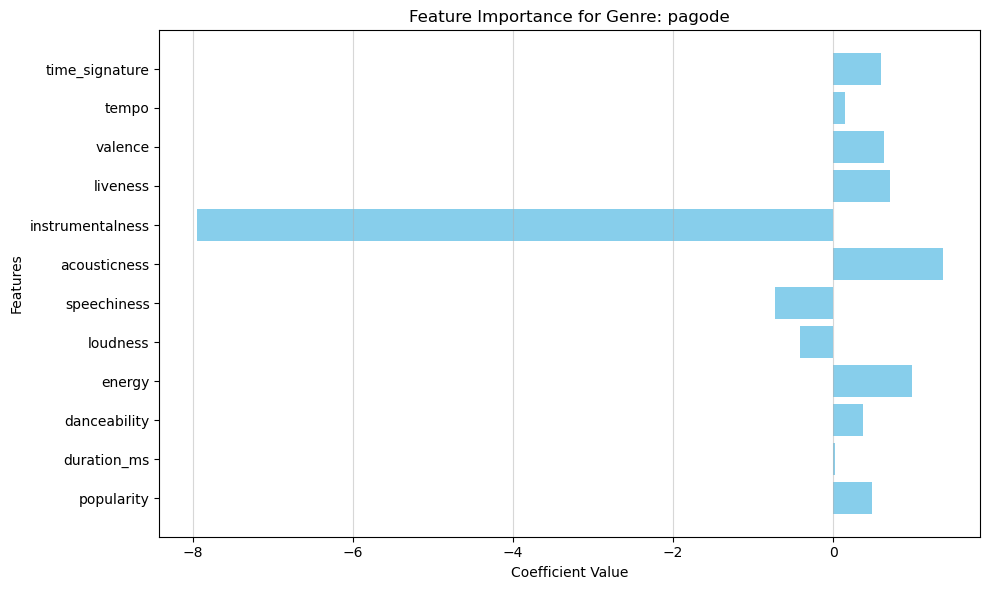

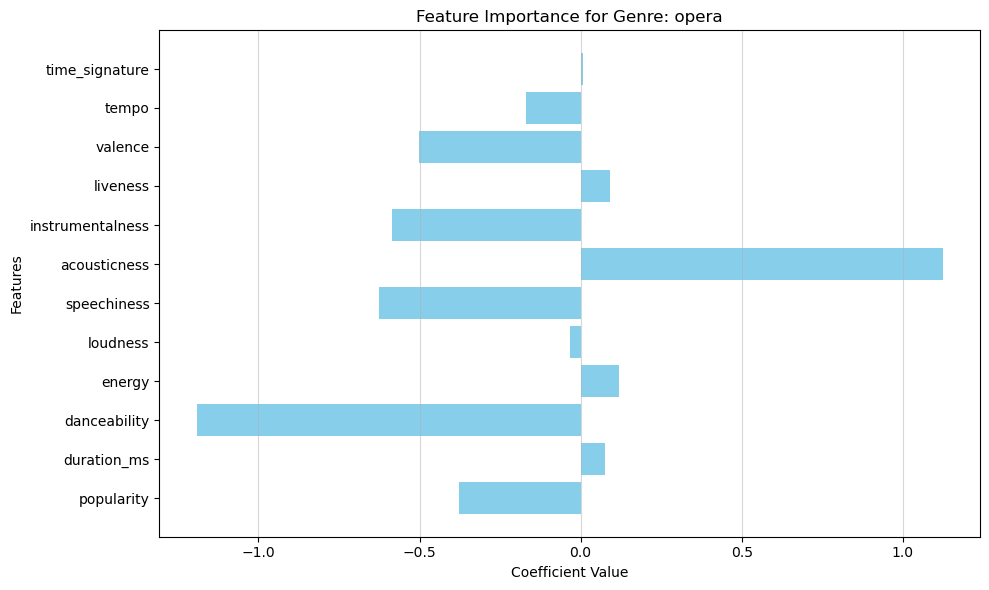

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Function to manually balance classes for a binary target
def balance_classes(X, y):
    # Combine X and y into a single DataFrame for sampling
    data_combined = pd.concat([X, y], axis=1)
    class_0 = data_combined[data_combined[y.name] == 0]
    class_1 = data_combined[data_combined[y.name] == 1]

    # Resample the minority class to match the majority class size
    if len(class_0) > len(class_1):
        class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
        balanced_data = pd.concat([class_0, class_1_upsampled])
    else:
        class_0_upsampled = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)
        balanced_data = pd.concat([class_0_upsampled, class_1])

    # Split back into X and y
    X_balanced = balanced_data[X.columns]
    y_balanced = balanced_data[y.name]
    return X_balanced, y_balanced

def logistic_regression_analysis(data, top_genres, predictors):
    results = []
    feature_importance = {}

    for genre in top_genres:
        y = data[f'is_{genre}']
        X = data[predictors]

        # Standardize the predictors
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=predictors)

        # Balance the classes manually
        X_balanced, y_balanced = balance_classes(X_scaled, y)

        # Split balanced data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.3, random_state=42
        )

        # Train logistic regression
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Store coefficients for feature importance
        feature_importance[genre] = model.coef_[0]

        # Make predictions
        y_pred = model.predict(X_test)

        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Genre': genre,
            'Precision (0)': report['0']['precision'],
            'Recall (0)': report['0']['recall'],
            'F1-Score (0)': report['0']['f1-score'],
            'Precision (1)': report['1']['precision'],
            'Recall (1)': report['1']['recall'],
            'F1-Score (1)': report['1']['f1-score'],
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1-Score': report['macro avg']['f1-score'],
        })

    # Convert to a DataFrame for easier handling
    results_df = pd.DataFrame(results)
    return results_df, feature_importance

def plot_feature_importance(feature_importance, predictors):
    for genre, coefficients in feature_importance.items():
        plt.figure(figsize=(10, 6))
        plt.barh(predictors, coefficients, color='skyblue')
        plt.title(f'Feature Importance for Genre: {genre}')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Features')
        plt.grid(axis='x', alpha=0.5)
        plt.tight_layout()
        plt.show()

def plot_roc_curves(data, top_genres, predictors):
    plt.figure(figsize=(15, 10))

    for genre in top_genres:
        y = data[f'is_{genre}']
        X = data[predictors]

        # Standardize the predictors
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=predictors)

        # Balance the classes manually
        X_balanced, y_balanced = balance_classes(X_scaled, y)

        # Split balanced data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.3, random_state=42
        )

        # Train logistic regression
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Predict probabilities for ROC curve
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot each ROC curve
        plt.plot(fpr, tpr, label=f'{genre} (AUC = {roc_auc:.2f})')

    # Plot baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

    # Customize plot
    plt.title('ROC Curves for Logistic Regression by Genre')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

# Full pipeline
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('dataset.csv')

    # Define top genres and predictors
    top_genres = ['acoustic', 'punk-rock', 'progressive-house', 'power-pop', 'pop', 'pop-film', 'piano', 'party', 'pagode', 'opera']
    predictors = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
                  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                  'tempo', 'time_signature']

    # Generate binary columns for top genres
    for genre in top_genres:
        data[f'is_{genre}'] = (data['track_genre'] == genre).astype(int)

    # Perform logistic regression analysis
    results_df, feature_importance = logistic_regression_analysis(data, top_genres, predictors)

    # Display results
    print("Classification Report Summary:")
    print(results_df)

    # Plot ROC curves
    plot_roc_curves(data, top_genres, predictors)

    # Plot feature importance
    plot_feature_importance(feature_importance, predictors)
